In [1]:
"""
My first object detection problem using CNN and Keras: detecting a single object in a image
    - Uses VGG16 as the base model

Based on: https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
@Author: Diogo Barros
@Version: 1.2
"""

import os
os.chdir("C:\\Users\\DBarros\\Documents\\SAFArI\\Machine Learning tryouts\\Datasets\Biota01 - boundingboxes0")

In [2]:
# import the necessary packages
import config
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
print("lol")

lol


In [6]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(config.ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
#(bounding box coordinates), along with the filenames of the individual images
data = []
targets = []
filenames = []
# getting rid of the initial trailing junk (alternatively set file to UTF-8-BOM coding)
rows[0]=rows[0][3:]
print("lol")


[INFO] loading dataset...
lol


In [7]:
# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startX, startY, endX, endY) = row

    # derive the path to the input image, load the image (in OpenCV format), and grab its dimensions
    imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    
    # scale the bounding box coordinates relative to the spatial dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    
    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)
print("lol")

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(config.TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()
print("lol")

In [21]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)
print("done")

done


In [22]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=config.INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=config.BATCH_SIZE,
    epochs=config.NUM_EPOCHS,
    verbose=1)
print("done")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

[INFO] saving object detector model...


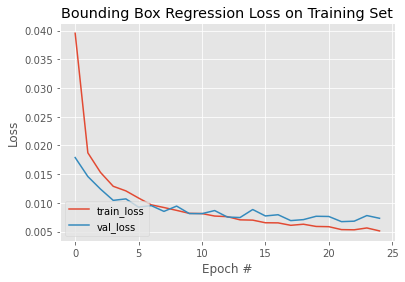

In [23]:
 # serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")
# plot the model training history
N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")

plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)

In [27]:
image = load_img("1.jpg", target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
preds = model.predict(image)[0]

In [28]:
print(preds)

[0.2078982  0.54970676 0.15009233 0.23096693]


In [29]:
print(model.predict(image))

[[0.2078982  0.54970676 0.15009233 0.23096693]]


In [31]:
H.history

{'loss': [0.03954486548900604,
  0.018725471571087837,
  0.015305175445973873,
  0.012898382730782032,
  0.012094446457922459,
  0.010849371552467346,
  0.009666118770837784,
  0.009199589490890503,
  0.008703164756298065,
  0.008183465339243412,
  0.008147861808538437,
  0.007714365608990192,
  0.007610312197357416,
  0.007054679095745087,
  0.007003809791058302,
  0.006546815391629934,
  0.006526479963213205,
  0.006102206185460091,
  0.006290988996624947,
  0.005905051715672016,
  0.00586186395958066,
  0.005355380941182375,
  0.005319157615303993,
  0.00564208347350359,
  0.005126320291310549],
 'val_loss': [0.017900338396430016,
  0.01459850836545229,
  0.012404111213982105,
  0.010446865111589432,
  0.010702459141612053,
  0.00926734134554863,
  0.009534111246466637,
  0.008525469340384007,
  0.009450382553040981,
  0.00814745668321848,
  0.008137896656990051,
  0.008669773116707802,
  0.007542403414845467,
  0.007455825340002775,
  0.008850649930536747,
  0.007732670288532972,
 

In [36]:
H.params

{'verbose': 1, 'epochs': 25, 'steps': 9}